# Python開発テクニック練習ノートブック
## 2021年度ver

## このノートブックについて
数式の実装には多くの解があります．例えば，行列演算の実装はfor文による実装．行列計算ライブラリによる実装と大きく分けて二通りがあります．

このノートブックでは古川研究室でよく使われる行列演算のテクニックをできるだけ網羅してまとめました．またそれを実際に実行できながら体系的に理解・学習できるようになることを目標に作りました．

## 事前知識
このノートブックでも必要再現の操作は抑えますが，事前知識として以下の本を読むことを推奨します．

[Dropboxにpdf](https://www.dropbox.com/s/7r6cbcux1br1jhb/%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8BPython%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E5%85%A5%E9%96%80_pass.pdf?dl=0)あります．

- 「ゼロからつくるPython機械学習プログラミング入門」
  - chapter2：Python入門
  - chapter3：数学のおさらい


## 準備
### [Numpy](https://numpy.org/doc/stable/user/index.html)

NumpyはPythonで科学的な計算を行うための基本的なパッケージです。行列計算は機械学習に限らず数値計算の基本であり，Numpyはその行列計算を高速に計算します．

In [5]:
import numpy as np

In [22]:
A = np.eye(5)
print(A)
A.shape

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


(5, 5)

### [Matplotlib]()
MatplotlibはPythonの描画パッケージです． （ここで悩むのは研究の本質的じゃないので困ったら知ってる人に効くことをおすすめします．）

In [41]:
N = 10 # データ数
D = 2 # 次元数
X = np.arange(N*D).reshape(N,D)
print(X, X.shape)

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]] (10, 2)


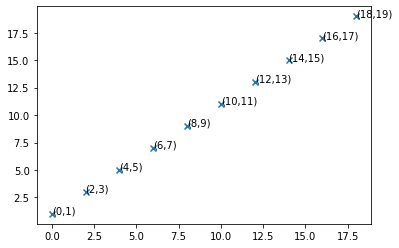

In [46]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], marker='x')
[plt.text(X[n,0], X[n,1], "("+str(X[n,0])+","+str(X[n,1])+")") for n in range(N)]
print("")

## テクニック"
1. ブロードキャスト（Broadcast）
2. メッシュグリッド(Meshgrid)
3. ファンシィインデックス(Fancy index)
4. アーグミン(Argmin)
5. リシェイプ(reshape)
6. アインサム

### 0. Reshape
さっきでてきた
> X = np.arange(N*D).reshape(N,D)

これです．

[reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)はデータの形を変更するときに使います．

In [200]:
N, D = 8,2
X = np.arange(N*D)
print("Xのshapeは", X.shape, N*D,"次元ベクトル（",N*D,"個要素がある）ということです．")
print(X)
X_m = X.reshape(N,D)
print("\n")
print("これに対して, N, D =",N,",",D,"として X.reshape(N,D)とすると", X_m.shape,"の行列になります")

Xのshapeは (16,) 16 次元ベクトル（ 16 個要素がある）ということです．
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


これに対して, N, D = 8 , 2 として X.reshape(N,D)とすると (8, 2) の行列になります


In [201]:
print("また，逆にベクトルに戻すには以下のようにする．")

print('X.reshape(-1)', X.reshape(-1))

また，逆にベクトルに戻すには以下のようにする．
X.reshape(-1) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


#### 演習問題0
以上の操作を任意の行列で実践せよ．

### 1. Broadcast
詳しい定義は[上島さんの解説記事](https://www.kamishima.net/mlmpyja/nbayes2/broadcasting.html).
使い方やイメージが欲しいなら[ここ](https://deepage.net/features/numpy-broadcasting.html).

In [142]:
I = 3
J = 4
A = np.arange(I)[:, None] + 1
print("Aのshapeは",A.shape," で，A自体は",'\n',A, "\n")
B = np.arange(I*J).reshape(I,J)
print("Bのshapeは",B.shape," で，B自体は",'\n', B, "\n")
print("この行列A,Bに対して B-A という演算をすると","\n", B - A,"となる")
# B - A

Aのshapeは (3, 1)  で，A自体は 
 [[1]
 [2]
 [3]] 

Bのshapeは (3, 4)  で，B自体は 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]] 

この行列A,Bに対して B-A という演算をすると 
 [[-1  0  1  2]
 [ 2  3  4  5]
 [ 5  6  7  8]] となる


行列演算はシェイプが違う行列同士の演算は定義されていない（というかできない）が， Broadcastをサポートしているライブラリではある条件を満たした場合特殊な演算ができる（されてしまう）．

今回のケース:
A行列(shape:(3,1))とB行列(shape:(3,4))はshapeが違うので演算できない． 
Broadcastでは， A行列(3,1)を列方向にコピーしてA_hat(3,4)の行列を作ってB - A_hatの演算をおこなう．

In [143]:
print("具体的には 以下のような演算をする")
A_hat = np.tile(A, J)
print("A_hat:","\n",A_hat)
print("B - A_hat:", "\n", B - A_hat,"\n", "先ほどの B-Aの演算と一致する．")

具体的には 以下のような演算をする
A_hat: 
 [[1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]]
B - A_hat: 
 [[-1  0  1  2]
 [ 2  3  4  5]
 [ 5  6  7  8]] 
 先ほどの B-Aの演算と一致する．


#### 演習問題1-a 
列方向のコピーではなく，行方向のコピーが行われるBroadcastの計算を実装せよ． (任意の四則演算）

In [144]:
C = np.arange(J)[None, :]
B / C

<ipython-input-144-966433f19b35>:2: RuntimeWarning: divide by zero encountered in true_divide
  B / C
<ipython-input-144-966433f19b35>:2: RuntimeWarning: invalid value encountered in true_divide
  B / C


array([[       nan, 1.        , 1.        , 1.        ],
       [       inf, 5.        , 3.        , 2.33333333],
       [       inf, 9.        , 5.        , 3.66666667]])

#### 演習問題1-b 
先ほどは行列(shapeが(I, J)のような変数）に対しての演算であった．3階のテンソルの変数（shapeが （I,J,K））に対して，任意のBroadcastの計算を実装せよ．

In [106]:
K = 2
D = np.arange(I*J*K).reshape(I,J,K)
E1 = np.arange(I*J).reshape(I,J,1)
E2 = np.arange(I*K).reshape(I,1,K)
print(D-E1,"\n",D-E2)

[[[ 0  1]
  [ 1  2]
  [ 2  3]
  [ 3  4]]

 [[ 4  5]
  [ 5  6]
  [ 6  7]
  [ 7  8]]

 [[ 8  9]
  [ 9 10]
  [10 11]
  [11 12]]] 
 [[[ 0  0]
  [ 2  2]
  [ 4  4]
  [ 6  6]]

 [[ 6  6]
  [ 8  8]
  [10 10]
  [12 12]]

 [[12 12]
  [14 14]
  [16 16]
  [18 18]]]


### 2. Meshgrid

[Meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)は，以下のような図の二次元空間の格子点の座標を取得したいときに使われる関数です．

この緑線とオレンジ線の交点の座標を求めましょう


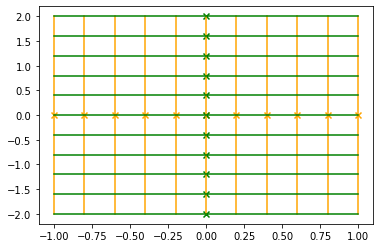

In [152]:
K = 11
A = np.linspace(-1,1,K)
B = np.linspace(-2,2,K)
plt.scatter(A,np.zeros(A.shape), color='orange', marker='x')
plt.scatter(np.zeros(B.shape),B, color='g', marker='x')
[plt.plot(np.tile(A[i],K), B, color='orange') for i in range(K)]
[plt.plot(A, np.tile(B[i], K),  color='g') for i in range(K)]
print("この緑線とオレンジ線の交点の座標を求めましょう")

In [164]:
XX, YY = np.meshgrid(A,B)
print("XXのshapeは", XX.shape, 'YYのshapeは', YY.shape, "となる")
print("XX")
print(XX)
print("YY")
print(YY)

XXのshapeは (11, 11) YYのshapeは (11, 11) となる
XX
[[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
 [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]]
YY
[[-2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2. ]
 [-1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6 -1.6]
 [-1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2]
 [-0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8]
 [-0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4]
 [ 0.   0.   0.   0.   

x=i,y=-jの交点のx座標が$XX_{ij}$に，x=i,y=-jの交点のy座標が$YY_{ij}$に格納されている，

欲しいのは，

$M = \\
[(XX_{11}, YY_{11}),\\(XX_{12}, YY_{12}), \\(XX_{13}, YY_{13}), \\ \cdots, \\(XX_{KK}, YY_{KK)}] $

のような $\mathbf{R}^{(K*K)\times 2}$の二次元行列である.

In [ ]:
よって， reshapeを使ってKxKの行列を(K*K)のベクトルに直し， XXとYYを横にconcatenateする．

In [168]:
xx = XX.reshape(-1)
yy = YY.reshape(-1)
M = np.concatenate([xx[:,None], yy[:,None]], axis=1)
M.shape

(121, 2)

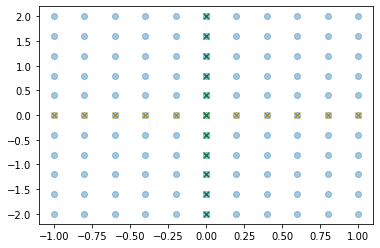

In [175]:
plt.scatter(A,np.zeros(A.shape), color='orange', marker='x')
plt.scatter(np.zeros(B.shape),B, color='g', marker='x')
plt.scatter(M[:, 0], M[:, 1], alpha=0.4)

#### 演習問題2

以上の操作を任意のベクトルの格子点で実践せよ

### 4. Argmin

数学において、最大値を与える引数あるいは最大点集合 (argument of the maximum) は関数がその最大値をとる定義域の元全体の成す集合である[note 1]。省略してarg max (もしくは argmax) と書かれる。最大値が函数の出力のうち最も大きいものを指すのと対照に、最大点は最大値を出力する入力の値を指す。

最大点集合は一般に複数の元を含むが、それは有限集合であることも無限集合であることも起こり得るし、空となることもあり得る。

例えば，先ほどのようなデータ点は以下のようなインデックスを持つ．

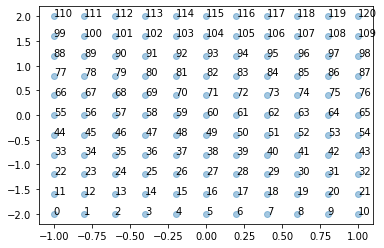

In [206]:
plt.scatter(M[:, 0], M[:, 1], alpha=0.4)
[plt.text(M[n, 0], M[n, 1], str(n)) for n in range(K*K)]
print("")

### 3. Fancy index

## 実践
1. ノルムと距離
2. 等間隔な座標
3. 描写

In [ ]:
### 1.ノルムと距離

In [ ]:
### 2. 等間隔な座標

In [99]:
### 3. 描写